## **Import Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install emoji
!pip install beautifulsoup4
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 25.4 MB/s eta 0:00:00


## **Persiapan Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

df1 = pd.read_csv('/content/drive/MyDrive/sc/27goemotions_no_multi_label_1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/sc/27goemotions_no_multi_label_2.csv')
df3 = pd.read_csv('/content/drive/MyDrive/sc/27goemotions_no_multi_label_3.csv')
df = pd.concat([df1, df2, df3], ignore_index=True)

df.head()


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Memilih kolom yang diinginkan
columns_to_keep = ['text', 'caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']
df = df[columns_to_keep]

# Menghapus baris yang semua nilainya 0 untuk kategori yang diinginkan
df = df[
    (df['caring'] != 0) |
    (df['love'] != 0) |
    (df['gratitude'] != 0) |
    (df['sadness'] != 0) |
    (df['fear'] != 0) |
    (df['anger'] != 0)
]

df.head()

,text,caring,love,gratitude,sadness,fear,anger
0,That game hurt.,0,0,0,1,0,0
3,Man I love reddit.,0,1,0,0,0,0
5,Right? Considering it’s such an important docu...,0,0,1,0,0,0
14,"I appreciate it, that's good to know. I hope I...",0,0,1,0,0,0
25,"Yup, not anymore. Keep your blood sugar up! It...",1,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28011 entries, 0 to 180600
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       28011 non-null  object
 1   caring     28011 non-null  int64 
 2   love       28011 non-null  int64 
 3   gratitude  28011 non-null  int64 
 4   sadness    28011 non-null  int64 
 5   fear       28011 non-null  int64 
 6   anger      28011 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.7+ MB


In [ ]:
df.duplicated().sum()

9426

In [ ]:
df['text'].duplicated().sum()

10702

In [ ]:
df = df.drop_duplicates(subset ='text')

In [ ]:
df['text'].duplicated().sum()

0

## **INFO DATA**

In [ ]:
df['sum']= df.iloc[:, 1:].sum(axis=1)
df.head(10)

,text,caring,love,gratitude,sadness,fear,anger,sum
0,That game hurt.,0,0,0,1,0,0,1
3,Man I love reddit.,0,1,0,0,0,0,1
5,Right? Considering it’s such an important docu...,0,0,1,0,0,0,1
14,"I appreciate it, that's good to know. I hope I...",0,0,1,0,0,0,1
25,"Yup, not anymore. Keep your blood sugar up! It...",1,0,0,0,0,0,1
30,I’m glad he’s okay but I’m even gladder it’s n...,0,0,1,0,0,0,1
33,"I just came home, what the fuck is this lineup...",0,1,0,0,0,0,1
45,Thanks for the info mate gonna watch out next ...,0,0,1,0,0,0,1
51,Gotta protect’em!,1,0,0,0,0,0,1
56,"Thanks, it was no effort at all.",0,0,1,0,0,0,1


In [ ]:
df['sum'].value_counts()

,count
sum,
1,17309


In [ ]:
df = df.drop('sum', axis=1)

In [ ]:
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']
emotion_counts = (df[emotions].sum())
emotion_counts

,0
caring,2551
love,3053
gratitude,4028
sadness,2703
fear,1179
anger,3795


In [ ]:
from sklearn.utils import resample
def balance_per_category(df, label_columns):
    balanced_data = []
    min_samples = df[label_columns].sum(axis=0).min()  # Ambil jumlah minimum label sebagai target

    for label in label_columns:
        category_data = df[df[label] == 1]  # Ambil data yang sesuai dengan label
        balanced_data.append(resample(category_data, n_samples=min_samples, random_state=42))

    return pd.concat(balanced_data).sample(frac=1, random_state=42)

In [ ]:
df = balance_per_category(df, emotions)
print(df[emotions].sum())

caring       1179
love         1179
gratitude    1179
sadness      1179
fear         1179
anger        1179
dtype: int64


In [ ]:
df['text'].duplicated().sum()

1450

In [ ]:
df = df.drop_duplicates(subset ='text')

In [ ]:
df['text'].duplicated().sum()

0

In [ ]:
df.duplicated().sum()

0

In [ ]:
df = balance_per_category(df, emotions)
print(df[emotions].sum())

caring       745
love         745
gratitude    745
sadness      745
fear         745
anger        745
dtype: int64


In [ ]:
df.iloc[15]

,161327
text,"Hurr durr, put well regulated back in the cons..."
caring,0
love,0
gratitude,0
sadness,0
fear,0
anger,1


In [ ]:
df = df.reset_index(drop=True)
df.head(10)

,text,caring,love,gratitude,sadness,fear,anger
0,"God, [NAME] looks rough.",0,0,0,0,1,0
1,"The irony is, she's probably been wishing for ...",0,0,0,1,0,0
2,That man has such epic face,0,1,0,0,0,0
3,"Nah dude, cats care about you more than anythi...",1,0,0,0,0,0
4,Excellent find. Panels like these are a very d...,0,1,0,0,0,0
5,"6lbs is a lap dog, if someone shoots that caus...",0,0,0,0,1,0
6,I'm convinced that libfems all hate themselves...,0,0,0,0,0,1
7,A joke of a mock and I usually refrain from be...,1,0,0,0,0,0
8,GUYS WHAT IF THE PEOPLE WHO ARE UPVOTING THE H...,0,0,0,0,1,0
9,Oh my gosh! That light house!! Its terrifying!!,0,0,0,0,1,0


### **Split Data**

In [ ]:
from sklearn.model_selection import train_test_split
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']


# Misalkan dataset adalah DataFrame dengan fitur `X` dan label `y`
X = df['text']
y = df[emotions].copy()

# Langkah 1: Pisahkan data training (80%) dan sisanya (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Langkah 2: Pisahkan data testing dan validasi dari sisanya (masing-masing 50% dari 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Hasil
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)

Training set: (3576,) (3576, 6)
Validation set: (447,) (447, 6)
Testing set: (447,) (447, 6)


In [ ]:
import os

# Gabungkan data dan simpan ke CSV
datasets = {
    "train_data.csv": pd.concat([X_train, y_train], axis=1),
    "val_data.csv": pd.concat([X_val, y_val], axis=1),
    "test_data.csv": pd.concat([X_test, y_test], axis=1),
}

# Buat folder untuk menyimpan file CSV jika belum ada
output_folder = "/content/drive/MyDrive/sc"

# Simpan dataset ke dalam file CSV
for filename, df in datasets.items():
    df.to_csv(os.path.join(output_folder, filename), index=False)

print("Data berhasil dibagi dan disimpan dalam folder 'output_data'")


Data berhasil dibagi dan disimpan dalam folder 'output_data'


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/sc/train_data.csv')
df_train = df_train.reset_index(drop=True)

In [ ]:
df_train.head()

,text,caring,love,gratitude,sadness,fear,anger
0,"I know. Maybe if they realize this, they'll st...",0,0,0,0,1,0
1,And [NAME] should go sell his wife's ketchup. ...,0,0,0,0,0,1
2,Wow excellent shot,0,0,1,0,0,0
3,That makes me feel even pettier. Thanks!,0,0,1,0,0,0
4,My mom and I do the same exact thing. I hate it.,0,0,0,1,0,0


In [ ]:
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

In [ ]:
emotion_counts = (df_train[emotions].sum())
emotion_counts

,0
caring,595
love,601
gratitude,611
sadness,579
fear,602
anger,588


In [ ]:
df_val = pd.read_csv('/content/drive/MyDrive/sc/val_data.csv')
df_val = df_val.reset_index(drop=True)

In [ ]:
df_val.head()

,text,caring,love,gratitude,sadness,fear,anger
0,"They probably take slight step back, by that I...",0,0,0,1,0,0
1,"Wow that's a burden, I'm sorry.",0,0,0,1,0,0
2,One elite run stopper please thanks,0,0,1,0,0,0
3,How scary! She loves you! I hope you are ok.,0,1,0,0,0,0
4,Tell her off yourself (and poke her in the bac...,0,0,0,1,0,0


In [ ]:
emotion_counts = (df_val[emotions].sum())
emotion_counts

,0
caring,61
love,76
gratitude,71
sadness,84
fear,78
anger,77


In [ ]:
print(df_train.shape)
print(df_val.shape)

(3576, 7)
(447, 7)


## **Cleaning Data**

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [ ]:
df_train['text'] = df_train['text'].apply(text_preprocessing_pipeline)
df_val['text'] = df_val['text'].apply(text_preprocessing_pipeline)

In [ ]:
df_train.head()

,text,caring,love,gratitude,sadness,fear,anger
0,i know maybe if they realize this they will st...,0,0,0,0,1,0
1,and should go sell his wifes ketchup he is goo...,0,0,0,0,0,1
2,wow excellent shot,0,0,1,0,0,0
3,that makes me feel even pettier thanks,0,0,1,0,0,0
4,my mom and i do the same exact thing i hate it,0,0,0,1,0,0


### **Train Model**

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

if device == 'cuda':
    print(f"Using CUDA (GPU): {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Using CUDA (GPU): Tesla T4


In [ ]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 200
TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 2e-5
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
target_cols = [col for col in df_train.columns if col not in ['text']]
target_cols

['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.text
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
train_dataset = BERTDataset(df_train, tokenizer, MAX_LEN)
valid_dataset = BERTDataset(df_val, tokenizer, MAX_LEN)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=4, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=4, shuffle=False, pin_memory=True)

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.

class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('roberta-base')
#         self.l2 = torch.nn.Dropout(0.3)
        self.fc = torch.nn.Linear(768,6)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
#         output_2 = self.l2(output_1)
        output = self.fc(features)
        return output

model = BERTClass()
model.to(device);

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = AdamW(params =  model.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)

In [ ]:
train_losses = []
val_losses = []

In [ ]:
def train(epoch):
    model.train()
    running_loss = 0.0
    for _, data in enumerate(train_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)

        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{EPOCHS}, Training Loss: {epoch_loss:.4f}")

In [ ]:
def validation():
    model.eval()
    running_loss = 0.0
    fin_targets = []
    fin_outputs = []

    with torch.no_grad():
        for _, data in enumerate(valid_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)

            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            running_loss += loss.item()

            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    val_loss = running_loss / len(valid_loader)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")
    return fin_outputs, fin_targets

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)
    validation()

Epoch 1/20, Training Loss: 0.4747
Validation Loss: 0.3349
Epoch 2/20, Training Loss: 0.2655
Validation Loss: 0.2107
Epoch 3/20, Training Loss: 0.1802
Validation Loss: 0.1837
Epoch 4/20, Training Loss: 0.1370
Validation Loss: 0.1735
Epoch 5/20, Training Loss: 0.1006
Validation Loss: 0.1689
Epoch 6/20, Training Loss: 0.0765
Validation Loss: 0.1698
Epoch 7/20, Training Loss: 0.0630
Validation Loss: 0.1865
Epoch 8/20, Training Loss: 0.0492
Validation Loss: 0.1804
Epoch 9/20, Training Loss: 0.0442
Validation Loss: 0.1891
Epoch 10/20, Training Loss: 0.0424
Validation Loss: 0.1890
Epoch 11/20, Training Loss: 0.0364
Validation Loss: 0.1865
Epoch 12/20, Training Loss: 0.0304
Validation Loss: 0.1859
Epoch 13/20, Training Loss: 0.0286
Validation Loss: 0.1930
Epoch 14/20, Training Loss: 0.0261
Validation Loss: 0.1883
Epoch 15/20, Training Loss: 0.0259
Validation Loss: 0.1927
Epoch 16/20, Training Loss: 0.0192
Validation Loss: 0.1976
Epoch 17/20, Training Loss: 0.0215
Validation Loss: 0.2031
Epoch 

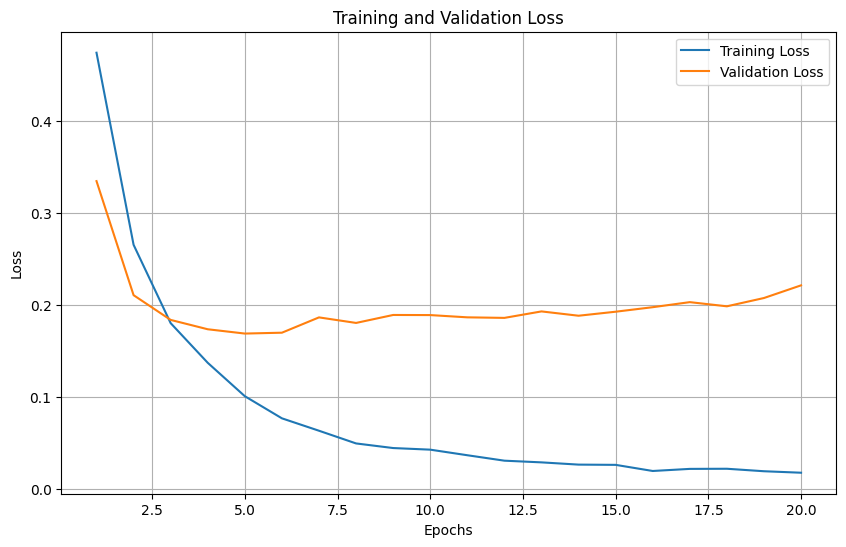

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# After validation phase
outputs, targets = validation()
outputs = np.array(outputs) >= 0.3  # Apply thresholding to convert probabilities to binary labels

# Calculate metrics
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
precision = metrics.precision_score(targets, outputs, average='macro')
recall = metrics.recall_score(targets, outputs, average='macro')

Validation Loss: 0.2214


In [ ]:
# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Micro): {f1_score_micro:.4f}")
print(f"F1 Score (Macro): {f1_score_macro:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")

Accuracy: 0.8389
F1 Score (Micro): 0.8461
F1 Score (Macro): 0.8454
Precision (Macro): 0.8394
Recall (Macro): 0.8573


In [ ]:
## Save only the model's state_dict
torch.save(model.state_dict(), '/content/drive/MyDrive/sc/emotion_model.pth')
print("Model saved!")


Model saved!


In [ ]:
import pickle

# Save the model
with open('/content/drive/MyDrive/sc/emotion_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as 'model.pkl'")


Model saved as 'model.pkl'


In [ ]:
from sklearn.metrics import classification_report
# Print Classification Report
print("\nClassification Report:")
print(classification_report(targets, outputs, target_names=target_cols))



Classification Report:
              precision    recall  f1-score   support

      caring       0.72      0.84      0.77        61
        love       0.94      0.95      0.94        76
   gratitude       0.93      0.96      0.94        71
     sadness       0.90      0.73      0.80        84
        fear       0.80      0.91      0.85        78
       anger       0.76      0.77      0.76        77

   micro avg       0.84      0.85      0.85       447
   macro avg       0.84      0.86      0.85       447
weighted avg       0.84      0.85      0.85       447
 samples avg       0.85      0.85      0.85       447



In [ ]:
def predict(text):
    # Preprocess input text
    text = text_preprocessing_pipeline(text)
    inputs = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=MAX_LEN,
        padding='max_length',
        return_token_type_ids=True
    )

    ids = torch.tensor(inputs['input_ids']).unsqueeze(0).to(device)
    mask = torch.tensor(inputs['attention_mask']).unsqueeze(0).to(device)
    token_type_ids = torch.tensor(inputs["token_type_ids"]).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(ids, mask, token_type_ids)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        outputs = outputs >= 0.3  # Binarize the predictions

    # List of emotion categories (adjust based on your dataset)
    emotion_labels = ['joy', 'love', 'gratitude', 'sadness', 'fear', 'anger']

    # Get the names of emotions that have a True prediction
    detected_emotions = [emotion_labels[i] for i in range(len(emotion_labels)) if outputs[0][i]]

    # Return the detected emotions as a string or list
    return detected_emotions if detected_emotions else "No emotion detected"



In [ ]:
# Example prediction
sample_text = "It really is! I loved everything about it. I'm so happy my friend told me about the franchise :)"
predictions = predict(sample_text)
print(predictions)

['love']


In [ ]:

# Example prediction
sample_text = "I’m very sorry for the loss of your friend."
predictions = predict(sample_text)
print(predictions)

['sadness']
